# Music Genre Classification (Multi Class)

This script trains a machine learning model to classify multiple music genres for a single song based on its lyrics. The model is trained using a dataset containing songs with corresponding lyrics and genres. Genres are represented as lists of strings, allowing for the prediction of multiple genres for a single song.

## Input Requirements
- The input dataset should be provided as a CSV file with the following columns:
    - `song`: String, representing the song name.
    - `artist`: String, representing the artist name.
    - `genres`: List of strings, representing the music genres associated with the song.
    - `lyrics`: String, representing the lyrics of the song.

## Dependencies
- Pandas
- NumPy
- TensorFlow (Keras)
- Scikit-learn
- Seaborn
- Matplotlib
- JSON

## Configuration
The configuration file 'config.json' includes settings such as the word embeddings file, word embedding dimensions, input length, and genre mappings.

## Execution
1. Load the dataset using the `load_datachunks` function or 'pd.read_csv(desired_dataset)'.
2. Visualize the distribution of genres using the `visualize_data` function.
3. Split the dataset into training (70%), testing (15%), and validation (15%) sets.
4. Convert dataframes into inputs for processing.
5. Train models, including LSTM and CNN, and evaluate their performance.
6. Save the best-performing model to a file ('models/model_<model_name>.keras').

Note: Ensure the dataset follows the specified format for successful execution.

In [18]:
import pandas as pd
import ast
import numpy as np

from utils.data_prep import dataset_to_X_y, load_datachunks
from utils.data_visualization import visualize_data, plot_confusion_matrix

from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, GlobalMaxPooling1D, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

import json
import random

In [2]:
json_file_path = 'config.json'
with open(json_file_path, 'r') as json_file:
    config_dict = json.load(json_file)

In [3]:
# Extracting global constants from the configuration
ALL_GENRES = config_dict['ALL_GENRES']  # All possible genres
GENRE_TO_INDEX = config_dict['GENRE_TO_INDEX']  # Mapping of genres to indices
INDEX_TO_GENRE = {index: genre for genre, index in GENRE_TO_INDEX.items()}  # Reverse mapping of indices to genres
WORD_EMBED_FILE = config_dict['WORD_EMBED_FILE']  # File containing word embeddings
DIMENSION_LENGTH = config_dict['WORD_EMBED_LEN']  # Dimension length of word embeddings
WORDS_PER_LINE = config_dict['INPUT_LENGTH']  # Number of words in each line of the lyrics

## Create Word Embeddings

In [4]:
def get_word_emb_dict():
    """
    Retrieves a dictionary of word embeddings from a specified file.

    Returns:
        dict: A dictionary where each word is a key, and the corresponding value is a NumPy array
              representing its word embedding.

    Note:
        The file format is assumed to have each line structured as 'word value1 value2 ... valueN'.
        The function skips lines that do not adhere to this format.
    """
    embedding = dict()
    with open(WORD_EMBED_FILE, 'r', encoding="utf8") as f:
        for line in f.readlines():
            line = line.split(' ')       
            try:
                embedding[line[0]] = np.array(line[1:], dtype=float)
            except:
                continue 
    return embedding
# get our word embeddings dictionary to convert words to embeddings
word_embeddings = get_word_emb_dict()


## Create Models

In [5]:
def get_lstm():
    """
    Creates and returns a Long Short-Term Memory (LSTM) neural network model for sequence processing.

    Returns:
        Sequential: A Keras Sequential model configured with LSTM layers and suitable for sequence processing tasks.

    Note:
        This function creates a model with two LSTM layers, each followed by a dropout layer for regularization.
        It includes Dense layers for further processing and outputs the probabilities for each class using softmax activation.
    """
    model = Sequential([
        LSTM(256, return_sequences=True),
        Dropout(0.2),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01), 
              activity_regularizer=regularizers.l1(0.01)),
        Dense(len(ALL_GENRES.keys()), activation='softmax')  # Number of classes (sentiment categories)
    ])
    return model


def get_cnn():
    """
    Creates and returns a Convolutional Neural Network (CNN) model for sequence processing.

    Returns:
        Sequential: A Keras Sequential model configured with Conv1D layers and suitable for sequence processing tasks.

    Note:
        This function creates a model with a Conv1D layer followed by global max pooling, additional Dense layers,
        and dropout for regularization. It outputs the probabilities for each class using softmax activation.
    """
    FILTERS = 250  # Number of filters in the Convnet
    KERNEL_SIZE = 3  # Window size of 3 tokens (how many tokens to read at a time)

    cnn_model = Sequential()
    cnn_model.add(Conv1D(FILTERS, KERNEL_SIZE, padding='valid', activation='relu', strides=1,
                         input_shape=(WORDS_PER_LINE, DIMENSION_LENGTH)))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(250))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Activation('relu'))
    cnn_model.add(Dense(len(ALL_GENRES.keys())))
    cnn_model.add(Activation('softmax'))

    return cnn_model

## Model Training + Evaluation

In [6]:
def train_model(model, train_data, val_data, epochs=10):
    """
    Trains a neural network model on the provided training data and validates it on the validation data.

    Args:
        model (Sequential): A Keras Sequential model to be trained.
        train_data (tuple): Tuple containing training input data (x_train) and corresponding labels (y_train).
        val_data (tuple): Tuple containing validation input data (x_val) and corresponding labels (y_val).
        epochs (int, optional): Number of training epochs. Defaults to 10.

    Returns:
        Tuple: A tuple containing the trained model and the training history.

    Note:
        This function compiles the model using categorical cross-entropy loss and Adam optimizer.
        It incorporates early stopping based on validation loss to prevent overfitting during training.
    """
    x_train, y_train = train_data
    x_val, y_val = val_data

    # Define optimizer and compile
    optimizer = Adam(learning_rate=.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Create early stopping object
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping])

    return model, history

def eval_model(model, test_data):
    
    """
    Evaluates the performance of a given model on test data, calculating accuracy and visualizing the confusion matrix.

    Parameters:
    model: Trained machine learning model.
    test_data (tuple): Tuple containing test features (x_test) and corresponding labels (y_test).

    Returns:
    Accuracy of the model on the test data.
    """
    
    # get data we can train with 
    x_test, y_test = test_data

    # Evaluate model on test data
    score = model.evaluate(x_test, y_test, verbose=1)

    # Calculate precision, recall, F1 score
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test_argmax = np.argmax(y_test, axis=1)
    
    acc = accuracy_score(y_test_argmax, y_pred)
    #print('Precision:', precision_score(y_test_argmax, y_pred, average='weighted'))
    #print('Recall:', recall_score(y_test_argmax, y_pred, average='weighted'))
    #print('F1 score:', f1_score(y_test_argmax, y_pred, average='weighted'))
    #print('Accuracy:', acc)
    
    plot_confusion_matrix(y_test_argmax, y_pred, INDEX_TO_GENRE)
    
    return acc 

In [7]:
def train_and_evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    
    Iterates through a dictionary of model names and corresponding functions to get models.
    Trains each model, evaluates its performance, and selects the best-performing model.
    
    Parameters:
    X_train, y_train (array-like): Training data.
    X_val, y_val (array-like): Validation data.
    
    Returns:
    the best model and its name.
    """
    
    best_score = 0
    best_model = None
    best_model_name = ''

    for model_name, get_model_func in models.items():
        print("Training:", model_name)
        model = get_model_func()
        model, hist = train_model(model, (X_train, y_train), (X_val, y_val))
        score = eval_model(model, (X_test, y_test))

        if score > best_score:
            best_score = score
            best_model = model
            best_model_name = model_name

    print("The best model is {} with an accuracy of {}".format(best_model_name, best_score))
    return best_model, best_model_name, best_score

#### Load in Data

In [38]:
 # load in data 
df = load_datachunks() # you can use this to load in the datachunk csv's (you can specify how many chunks to load in)
# df = pd.read_csv('data/custom/top100_dataset.csv') # alternatively you can train using the custom dataset or your own dataset like this
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x)) # convert list string back to list python object
df = df[df['genres'].apply(lambda x: bool(x))] # discard song if no genres
df['genres'] = df['genres'].apply(lambda x: [x[0]]) # take the first genre from the genre list for each song
df.head()

Loaded dataframe chunks Successfully


,song,artist,genres,lyrics
0,Killa Cam,Cam'ron,[hip hop],"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,JAY-Z,[hip hop],"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,Fabolous,[hip hop],Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,Cam'ron,[hip hop],[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,Lil Wayne,[hip hop],"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


count        5716
unique         10
top       hip hop
freq         5194
dtype: object


c:\Users\Mikea\Song_Genre_Prediction\utils\data_visualization.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=genres_series, order=genres_series.value_counts().index, palette=pal)


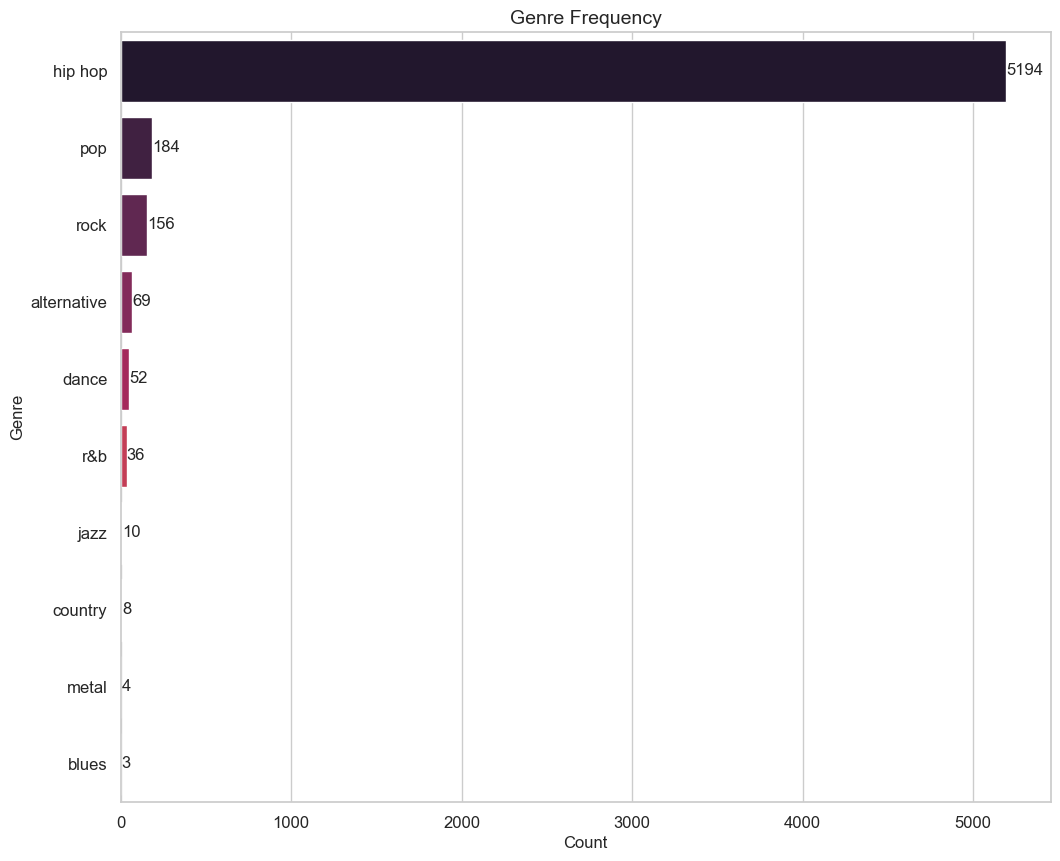

In [25]:
# visualize it so we can see 
visualize_data(df['genres'])

#### Balance dataset (Optional)

In [63]:
def balance_df(df, genre_column='genres', random_seed=None):
    """
    Get the indices of rows to create a balanced DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - genre_column (str): Name of the column containing genre lists.
    - random_seed (int): Seed for reproducibility in random sampling.

    Returns:
    - list: Indices of rows for a balanced DataFrame.
    """
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    # Identify unique genres and their counts
    unique_genres, genre_counts = np.unique(np.concatenate(df["genres"].values), return_counts=True)

    # Calculate the desired number of samples per genre (average count)
    average_entries_per_genre = np.median(genre_counts).astype(int)
    print(average_entries_per_genre)
    # Get the indices for a balanced DataFrame
    balanced_indices = []
    for genre, count in zip(unique_genres, genre_counts):
        genre_indices = df[df[genre_column].apply(lambda x: genre in x)].index
        if count > average_entries_per_genre:
            sampled_indices = np.random.choice(genre_indices, size=average_entries_per_genre, replace=False)
            balanced_indices.extend(sampled_indices)

    return df.loc[balanced_indices]

44
count             220
unique              5
top       alternative
freq               44
dtype: object


c:\Users\Mikea\Song_Genre_Prediction\utils\data_visualization.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=genres_series, order=genres_series.value_counts().index, palette=pal)


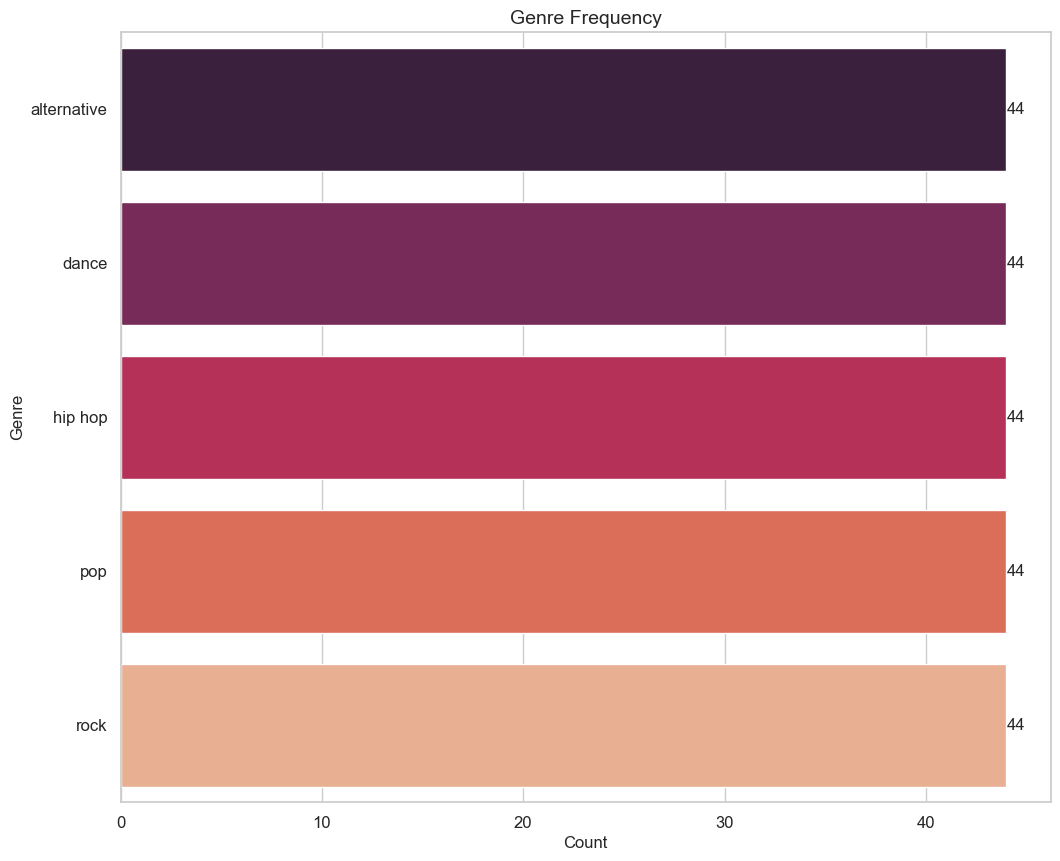

In [61]:
df = balance_df(df)
visualize_data(df['genres'])

#### Preprocess data for training

In [62]:
# Split the DataFrame into training (70%), testing (15%), and validation (15%)
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# turn dataframes into inputs we can process 
X_train, y_train = dataset_to_X_y(train_df, word_embeddings)
X_test, y_test = dataset_to_X_y(test_df, word_embeddings)
X_val, y_val = dataset_to_X_y(val_df, word_embeddings)

#### Train and determine best model

Training: single_class_lstm

Epoch 1/10


5/5 [==============================] - 22s 3s/step - loss: 3.1589 - accuracy: 0.2143 - val_loss: 3.1125 - val_accuracy: 0.1212
Epoch 2/10
5/5 [==============================] - 12s 2s/step - loss: 2.9111 - accuracy: 0.2792 - val_loss: 2.7724 - val_accuracy: 0.3030
Epoch 3/10
5/5 [==============================] - 13s 3s/step - loss: 2.7242 - accuracy: 0.1494 - val_loss: 2.5983 - val_accuracy: 0.3030
Epoch 4/10
5/5 [==============================] - 14s 3s/step - loss: 2.5964 - accuracy: 0.2597 - val_loss: 2.5843 - val_accuracy: 0.1212
Epoch 5/10
5/5 [==============================] - 15s 3s/step - loss: 2.5360 - accuracy: 0.2338 - val_loss: 2.4805 - val_accuracy: 0.1212
Epoch 6/10
5/5 [==============================] - 14s 3s/step - loss: 2.4790 - accuracy: 0.2013 - val_loss: 2.4146 - val_accuracy: 0.3333
Epoch 7/10
5/5 [==============================] - 13s 3s/step - loss: 2.4117 - accuracy: 0.2792 - val_loss: 2.4558 - val_accuracy: 0.2424
Epo

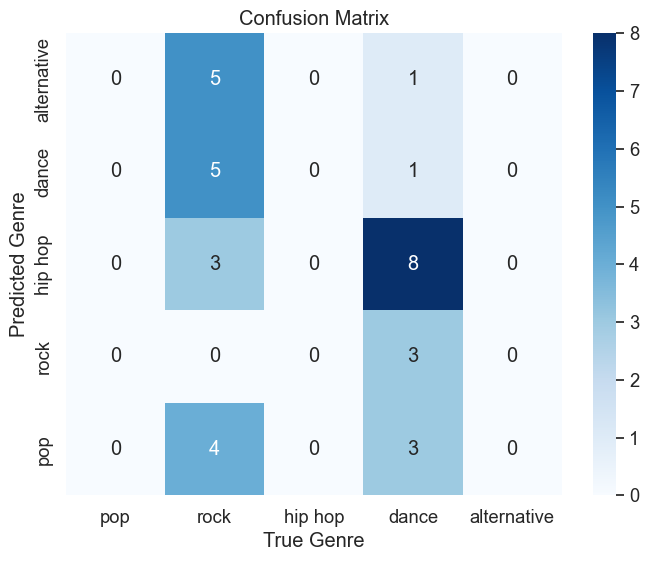

c:\Users\Mikea\Song_Genre_Prediction\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikea\Song_Genre_Prediction\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mikea\Song_Genre_Prediction\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

         pop       0.00      0.00      0.00         6
        rock       0.29      0.83      0.43         6
     hip hop       0.00      0.00      0.00        11
       dance       0.19      1.00      0.32         3
 alternative       0.00      0.00      0.00         7

    accuracy                           0.24        33
   macro avg       0.10      0.37      0.15        33
weighted avg       0.07      0.24      0.11        33

Training: single_class_cnn
Epoch 1/10
5/5 [==============================] - 2s 209ms/step - loss: 2.2304 - accuracy: 0.1299 - val_loss: 1.5864 - val_accuracy: 0.3030
Epoch 2/10
5/5 [==============================] - 1s 122ms/step - loss: 1.7453 - accuracy: 0.2922 - val_loss: 1.5563 - val_accuracy: 0.3333
Epoch 3/10
5/5 [==============================] - 1s 134ms/step - loss: 1.5406 - accuracy: 0.3182 - val_loss: 1.7121 - val_accuracy: 0.1212
Epoch 4/10
5/5 [========================

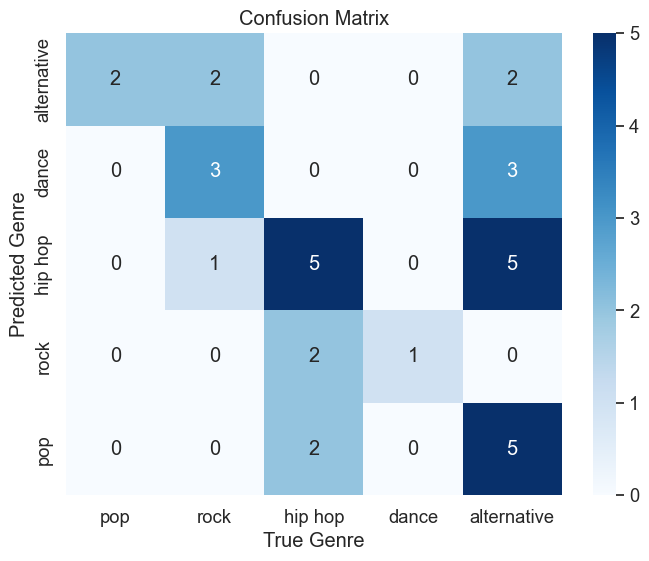

Classification Report:
               precision    recall  f1-score   support

         pop       1.00      0.33      0.50         6
        rock       0.50      0.50      0.50         6
     hip hop       0.56      0.45      0.50        11
       dance       1.00      0.33      0.50         3
 alternative       0.33      0.71      0.45         7

    accuracy                           0.48        33
   macro avg       0.68      0.47      0.49        33
weighted avg       0.62      0.48      0.49        33

The best model is single_class_cnn with an accuracy of 0.48484848484848486


In [64]:
# Define models
models = {
    'single_class_lstm': get_lstm,
    'single_class_cnn': get_cnn
}

# Train and evaluate models
best_model, best_model_name, best_score = train_and_evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test)

#### Save the best model

In [ ]:
print("The best model is {} with a accuracy of {}".format(best_model_name, best_score)) 
best_model.save('models/model_{}.keras'.format(best_model_name))